# Does the LSTM conserve water?

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/tommy/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import matplotlib as mpl
from tqdm import tqdm
from collections import defaultdict

mpl.rcParams['figure.dpi'] = 150

In [3]:
label_size = 14  # 10
plt.rcParams.update(
    {'axes.labelsize': label_size,
     'legend.fontsize': label_size,
     "font.size": 14,
    }
)

In [4]:
# data_dir = Path('data/')
data_dir = Path('/cats/datastore/data/')

assert data_dir.exists()

In [5]:
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data
from src.analysis.evaluation import join_true_pred_da
from src.models import load_model

# Read in the CAMELS data

In [6]:
# read in the training data
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")
ds['station_id'] = ds['station_id'].astype(int)

all_static = xr.open_dataset(data_dir / f'RUNOFF/interim/static/data.nc')
all_static['station_id'] = all_static['station_id'].astype(int)
static = all_static

# Read AWS Trained Models

In [7]:
# ealstm_less_vars = pd.read_csv(data_dir / "runs/ealstm_less_vars_2004_1707_1424/results_ealstm_less_vars_2004_1707_1424_E015.csv")
# ealstm_preds = xr.open_dataset(data_dir / "runs/ensemble/data_ENS.csv")
ealstm_ensemble_df = pd.read_csv(data_dir / "runs/ensemble_EALSTM/data_ENS.csv").drop("Unnamed: 0", axis=1)
ealstm_ensemble_df["time"] = pd.to_datetime(ealstm_ensemble_df["time"])
ealstm_preds = ealstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()

ealstm_preds["station_id"] = [int(sid) for sid in ealstm_preds["station_id"]]

In [8]:
lstm_ensemble_df = pd.read_csv("/cats/datastore/data/runs/ensemble/data_ENS.csv").drop("Unnamed: 0", axis=1)
lstm_ensemble_df["time"] = pd.to_datetime(lstm_ensemble_df["time"])
lstm_ensemble = lstm_ensemble_df.set_index(["station_id", "time"]).to_xarray()
lstm_preds = lstm_ensemble

# Calculate Runoff Coefficient

In [9]:
def assign_wateryear(dt):
    """https://stackoverflow.com/a/52615358/9940782"""
    dt = pd.Timestamp(dt)
    if dt.month >= 10:
        return(pd.datetime(dt.year+1,1,1).year)
    else:
        return(pd.datetime(dt.year,1,1).year)


ds_wy = ds.assign_coords(wy=("time", [assign_wateryear(dt) for dt in ds.time.values]))
lstm_preds_wy = lstm_preds.assign_coords(wy=("time", [assign_wateryear(dt) for dt in lstm_preds.time.values]))

## Compare the Runoff Coefficient 

In [10]:
wy_sum = ds_wy.groupby("wy").sum(dim="time")
runoff_coeff_obs = (wy_sum["discharge_spec"] / wy_sum["precipitation"]).mean("wy")
obs_rc = runoff_coeff_obs.to_dataframe("runoff_coeff")
obs_rc.head()

,runoff_coeff
station_id,
1001,0.263388
2001,0.608132
2002,0.355424
3003,0.656335
4001,0.840136


In [11]:
lstm_wy_sum = lstm_preds_wy.groupby("wy").sum(dim="time")
runoff_coeff_sim = (lstm_wy_sum["sim"] / wy_sum["precipitation"].sel(wy=lstm_wy_sum["wy"])).mean("wy")
sim_rc = runoff_coeff_sim.to_dataframe("runoff_coeff")
sim_rc.head()

,runoff_coeff
station_id,
1001,0.569393
2001,0.572132
2002,0.624176
3003,0.728468
4001,0.851075


In [12]:
rc_comparison = obs_rc.rename({"runoff_coeff": "obs",}, axis=1).join(sim_rc.rename({"runoff_coeff": "sim",}, axis=1))

# 20% Error of Water Balance

In [240]:
wy_sum = ds_wy.groupby("wy").sum(dim="time")

In [241]:
# How many stations are within 20% of error ...?
ref_value = 0.2 * ds["precipitation"].sum("time")
ref_value_upper = 0.5*ref_value
ref_value_lower = -0.5*ref_value

wb_calc = ds["precipitation"].sum("time") - ds["pet"].sum("time") - ds["discharge_spec"].sum("time")

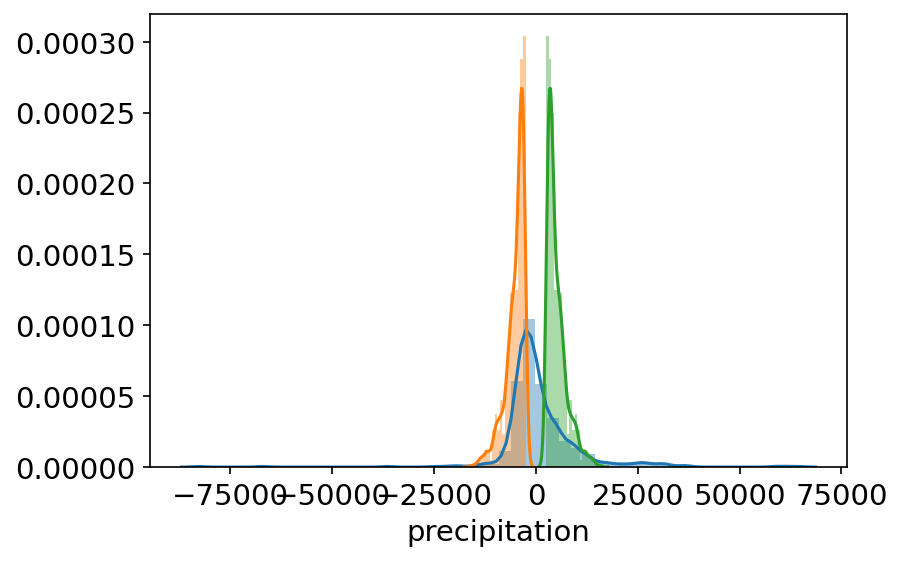

In [242]:
sns.distplot(wb_calc)
ax = plt.gca()
sns.distplot(ref_value_lower) # , ls="--", alpha=0.6)
sns.distplot(ref_value_upper) # , ls="--", alpha=0.6)

In [266]:
bool_wb = ((ref_value_lower < wb_calc) & (ref_value_upper > wb_calc))
(data_dir / "RUNOFF/bool_water_balance_20pct.nc").unlink()
bool_wb.to_netcdf(data_dir / "RUNOFF/bool_water_balance_20pct.nc")

In [267]:
bool_wb.where(bool_wb, drop=True)

<xarray.DataArray (station_id: 411)>
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])
Coordinates:
  * station_id  (station_id) int64 2001 4001 4003 6007 ... 96002 97002 101002

# Balance in All Stations

In [25]:
wy_sum = ds_wy.groupby("wy").sum(dim="time")
wy_mean = ds_wy.groupby("wy").mean(dim="time")

balance = (wy_sum["precipitation"] - wy_sum["pet"] - wy_sum["discharge_spec"]).mean("wy")
balance = (wy_mean["precipitation"] - wy_mean["pet"] - wy_mean["discharge_spec"]).mean("wy")
d = balance.to_dataframe("water_balance")

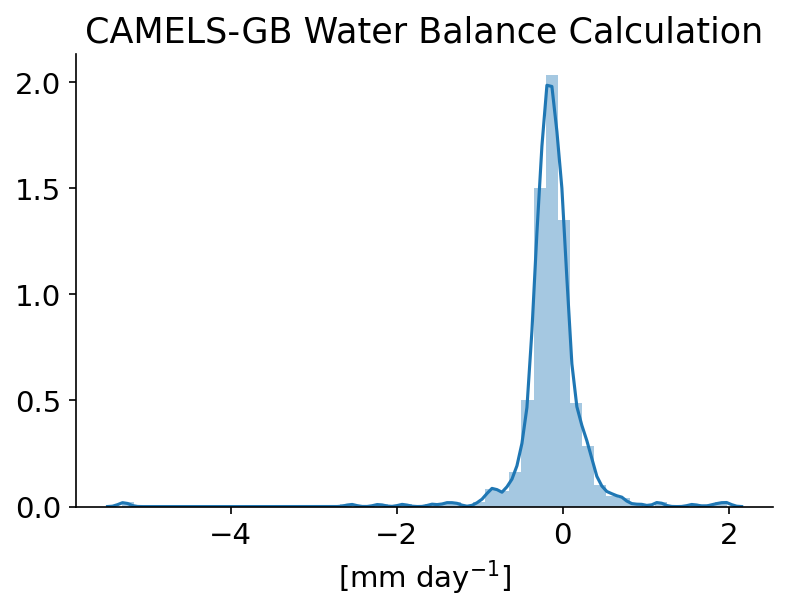

In [30]:
# sns.boxplot(data=d)
sns.distplot(d)
ax = plt.gca()
ax.set_xlabel("[mm day$^{-1}$]")
ax.set_title("CAMELS-GB Water Balance Calculation")
sns.despine()

# Water balance calculation for simulated Discharge

In [36]:
lstm_wy_sum = lstm_preds_wy.groupby("wy").sum(dim="time")
lstm_wy_mean = lstm_preds_wy.groupby("wy").mean(dim="time")

balance_sim = (wy_mean.sel(wy=lstm_wy_mean["wy"])["precipitation"] - wy_mean.sel(wy=lstm_wy_mean["wy"])["pet"] - lstm_wy_mean["sim"]).mean(dim="wy")
d_sim = balance_sim.to_dataframe("water_balance")

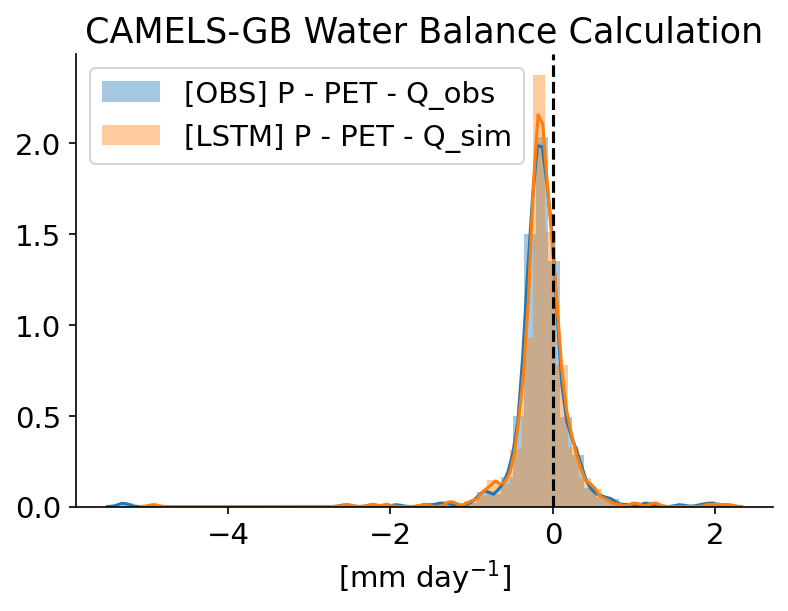

In [119]:
# sns.boxplot(data=d)
sns.distplot(d, label="[OBS] P - PET - Q_obs")
sns.distplot(d_sim, label="[LSTM] P - PET - Q_sim")
ax = plt.gca()
ax.set_xlabel("[mm day$^{-1}$]")
ax.set_title("CAMELS-GB Water Balance Calculation")
ax.legend()
ax.axvline(0, ls="--", color="k")
sns.despine()

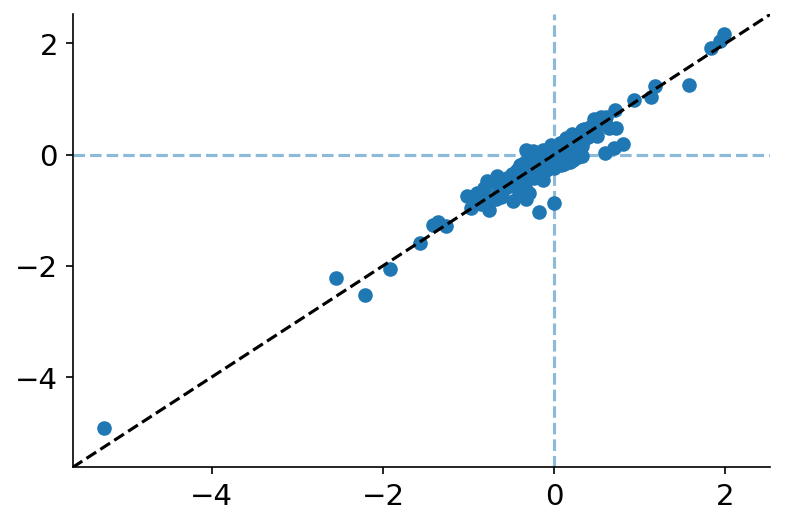

In [126]:
plt.scatter(d.loc[d_sim.index], d_sim)
ax = plt.gca()
xlim, ylim = ax.get_xlim(), ax.get_ylim()
axis_min = min(xlim[0], ylim[0])
axis_max = max(xlim[-1], ylim[-1])
ax.set_xlim(axis_min, axis_max)
ax.set_ylim(axis_min, axis_max)
ax.plot(np.linspace(axis_min, axis_max, 100), np.linspace(axis_min, axis_max, 100), color="k", ls="--", label="1:1 Line")

ax.axvline(0, ls="--", alpha=0.5)
ax.axhline(0, ls="--", alpha=0.5)
sns.despine()

# Precip - Q?

In [103]:
# lstm_wy_sum = lstm_preds_wy.groupby("wy").sum(dim="time")
# wy_sum = ds_wy.groupby("wy").sum(dim="time")

# wy_mean = ds_wy.groupby("wy").mean(dim="time")
# lstm_wy_mean = lstm_preds_wy.groupby("wy").mean(dim="time")

In [130]:
precip_minus_qsim = (wy_sum.sel(wy=lstm_wy_sum["wy"])["precipitation"] - lstm_wy_sum["sim"])
precip_minus_qobs = wy_sum.sel(wy=lstm_wy_sum["wy"])["precipitation"] - wy_sum.sel(wy=lstm_wy_sum["wy"])["discharge_spec"]

precip_minus_qsim_MEAN = (wy_mean.sel(wy=lstm_wy_mean["wy"])["precipitation"] - lstm_wy_mean["sim"])
precip_minus_qobs_MEAN = wy_mean.sel(wy=lstm_wy_mean["wy"])["precipitation"] - wy_mean.sel(wy=lstm_wy_mean["wy"])["discharge_spec"]
# .where((precip_minus_qsim < 0).mean(dim="wy") < 0, drop=True)

In [131]:
precip_minus_qsim_MEAN.mean("wy")

<xarray.DataArray (station_id: 669)>
array([ 1.02044961,  1.12280538,  1.03078111,  0.92945608,  0.22575348,
        1.32085763,  1.21425429,  1.14425365,  0.99369989,  1.09809058,
        1.08376053,  0.39679451,  0.76994085,  1.36887056,  0.98595861,
        1.1743155 ,  0.85131259,  1.65781681,  1.29256451,  0.87384845,
        1.02305113,  0.69648383,  1.09220464,  1.17799805,  1.25281227,
        1.01594784,  1.04431538,  1.04353175,  1.03962789,  1.04597467,
        0.98185927,  0.81962407,  0.90487399,  1.05433157,  0.67719248,
        0.35946811,  1.14313685,  0.90031884,  1.07232468,  1.14881684,
        1.15039003,  0.95105139,  1.04889331,  1.1981738 ,  1.24210221,
        1.25006854,  0.79384044,  1.16853691,  1.38076294,  3.124397  ,
        0.59381816,  1.4099114 ,  0.77382033, -0.4812638 ,  1.18805102,
        1.06255386,  1.57396646,  0.89925055,  1.10740417,  0.26521342,
        0.95430238,  1.12878184,  0.95725874,  1.71254689,  1.11489947,
        1.37948371,  1.04960666,  0.97397956,  1.61021121,  1.282097  ,
        1.67365089,  1.49370305,  0.68489432,  1.45452726,  1.32766183,
        0.96731899,  1.28818797,  1.08887201,  1.17467184,  1.15138341,
        1.1627942 ,  1.12430534,  1.26163157,  1.31270855,  1.31662972,
        1.25777696,  1.18295898,  1.07570933,  1.14062884,  1.45131542,
        1.00622128,  1.05044618,  1.16274278,  1.13074433,  0.69512969,
        1.16277369,  1.17288589,  1.15457616,  1.10032575,  0.76700236,
        1.19511452,  1.17122099,  1.329389  ,  1.22628837,  1.12489359,
        1.04834532,  0.99556872,  0.92722381,  1.58283038,  1.15062574,
        0.69832473,  1.38001308,  1.15740389,  1.60328067,  1.13559551,
        1.34690823,  1.24751013,  1.13247904,  0.77869576,  0.9447293 ,
        1.40185092,  1.51821066,  1.34423996,  1.08894468,  2.11012559,
        1.5136052 ,  1.08098807,  1.38131474,  1.30410397,  1.1367779 ,
        1.64558573,  1.11934407,  1.22656136,  1.14152653,  1.24115198,
        1.11705808,  1.18352094,  1.44592303,  1.05833664,  3.52973847,
        1.01663339,  1.18711014, -3.50961864,  1.35703985,  1.13212091,
        1.12067436,  0.50464525,  1.21726163,  1.21390741,  1.37790318,
        1.21258558,  1.56423264,  1.15364515, -1.10710269,  1.63854024,
        1.1294011 ,  0.98310107,  1.0303559 ,  1.47540654,  1.32365515,
        1.10047349,  2.39787997,  0.98506246,  1.24406131,  1.19222131,
        1.19063771,  1.42021914,  1.30869575,  1.20378747,  1.44849513,
        1.23053719,  1.15758129,  0.98070015,  0.76026351,  1.34937583,
        1.55797098,  1.64003583,  1.13888131,  1.10129206,  1.35459964,
        1.14296075,  1.50747295,  1.3453995 ,  1.21089966,  1.78157319,
        1.24934527,  1.39626366,  1.45720557,  1.10864121,  0.47964581,
        0.9044279 ,  1.19918024,  1.48314408,  1.2479184 ,  1.09413554,
        0.23461444,  1.51445294,  1.53734588,  1.34064775,  1.34661581,
        1.22339484,  1.37013607,  1.23227066,  1.28768104,  1.36296456,
        1.56730646,  1.20533711,  1.17973162,  1.32930199,  1.49517961,
        1.49244333,  1.23320886,  1.31347287,  1.37853829,  1.23888154,
        1.27320141,  1.22686213,  1.29014218,  1.30650499,  1.31913073,
        1.35831953,  1.23013943,  1.42201172,  1.3928407 ,  1.26141366,
        1.31829139,  1.27445132,  1.3353386 ,  1.22982293,  1.59657937,
        1.3539514 ,  1.25845284,  1.092626  ,  1.45734235,  1.4457615 ,
        1.66713254,  1.21647558,  1.35501344,  1.37048398,  1.22406484,
        1.48819702,  1.13992545,  1.16712104,  1.46494191,  1.42225921,
        1.34512473,  1.52990702,  1.35876229,  1.32758315,  1.36092652,
        1.3203152 ,  1.58761154,  1.67054511,  1.33666603,  1.26455408,
        1.36873006,  1.24810541,  1.34530115,  1.24822792,  1.17024067,
        1.10797783,  1.2040418 ,  1.29317308,  1.27068853,  1.22907771,
        1.12416108,  1.24721006,  1.34441299,  1.09494995,  1.15675088,
        1.30223267,  1.18232444,  1.1078469 ,  1.43813818,  1.49745452,
   

In [137]:
(precip_minus_qsim.mean(dim="wy") < 0 ).sum()
# runoff greater precip = rgp
# how many water years (/ 12) is runoff greater than precip?
rgp = (precip_minus_qsim < 0).groupby("station_id").sum("wy")
print(rgp.where(rgp > 0, drop=True).station_id.values)
rgp.where(rgp > 0, drop=True)

[15016 27038 27073 39061 44009 65008 89005]


<xarray.DataArray (station_id: 7)>
array([ 9., 11., 11.,  4.,  8., 10.,  4.])
Coordinates:
  * station_id  (station_id) int64 15016 27038 27073 39061 44009 65008 89005

In [133]:
(precip_minus_qobs.mean(dim="wy") < 0 ).sum()

<xarray.DataArray ()>
array(8)

In [139]:
# runoff greater precip
rgp_obs = (precip_minus_qobs < 0).groupby("station_id").sum("wy")
print(rgp_obs.where(rgp_obs > 0, drop=True).station_id.values)
rgp_obs.where(rgp_obs > 0, drop=True)

[  4001  12007  15016  15039  26006  27038  27073  28033  28115  39061
  44009  47018  63004  65001  65006  65008  66011  67018  69043  80004
  80005  84008  85004  89005 106001]


<xarray.DataArray (station_id: 25)>
array([ 1.,  2., 11.,  1., 12., 11., 12.,  1.,  3.,  7., 11.,  1.,  2.,
        2.,  1., 10.,  1.,  1.,  2.,  5.,  1.,  1.,  1.,  6.,  1.])
Coordinates:
  * station_id  (station_id) int64 4001 12007 15016 15039 ... 85004 89005 106001

,wb_obs,wb_sim
station_id,,
1001,-0.044049,-0.144567
2001,-0.074660,0.014793
2002,-0.100841,-0.091904
3003,0.109580,-0.177394
4001,-0.825773,-0.850148
...,...,...
101002,-0.016225,0.057574
101005,0.040882,0.070414
102001,-0.142957,-0.287669


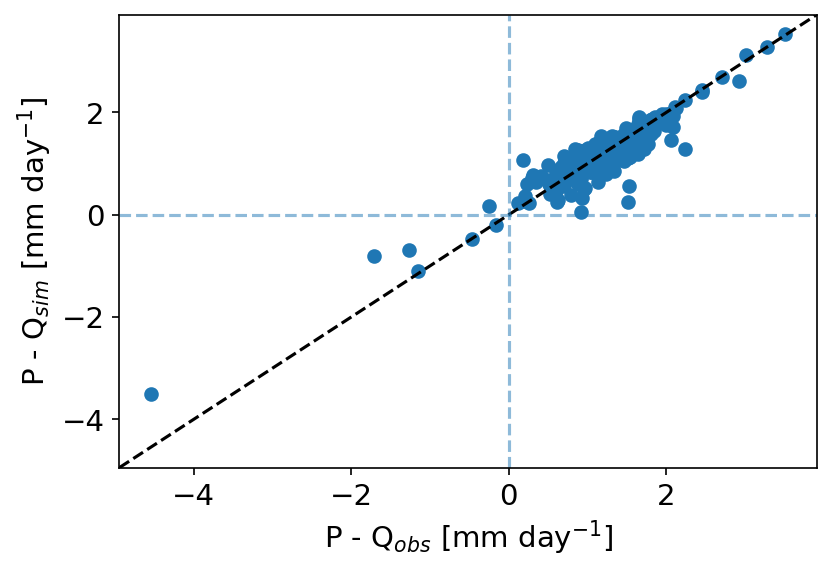

In [180]:
mm_per_year = True
reduce_water_year = False

for mm_per_year in [False]:
    for reduce_water_year in [True]:

        if mm_per_year: 
            wb_calculation_sim = precip_minus_qsim
            wb_calculation_obs = precip_minus_qobs
        else:
            wb_calculation_sim = precip_minus_qsim_MEAN
            wb_calculation_obs = precip_minus_qobs_MEAN

        if reduce_water_year:
            wb_calculation_sim = wb_calculation_sim.mean(dim="wy")
            wb_calculation_obs = wb_calculation_obs.mean(dim="wy")
            
        comparison_df = wb_calculation_sim.to_dataframe("wb_sim").join(wb_calculation_obs.to_dataframe("wb_obs")).reset_index()

        f, ax = plt.subplots()
        ax.scatter(comparison_df["wb_obs"], comparison_df["wb_sim"])
        xlim, ylim = ax.get_xlim(), ax.get_ylim()
        axis_min = min(xlim[0], ylim[0])
        axis_max = max(xlim[-1], ylim[-1])
        ax.set_xlim(axis_min, axis_max)
        ax.set_ylim(axis_min, axis_max)
        ax.plot(np.linspace(axis_min, axis_max, 100), np.linspace(axis_min, axis_max, 100), color="k", ls="--", label="1:1 Line")

        if mm_per_year:
            ax.set_xlabel("P - Q$_{obs}$ [mm yr$^{-1}$]")
            ax.set_ylabel("P - Q$_{sim}$ [mm yr$^{-1}$]")
        else:
            ax.set_xlabel("P - Q$_{obs}$ [mm day$^{-1}$]")
            ax.set_ylabel("P - Q$_{sim}$ [mm day$^{-1}$]")

        ax.axvline(0, ls="--", alpha=0.5)
        ax.axhline(0, ls="--", alpha=0.5)

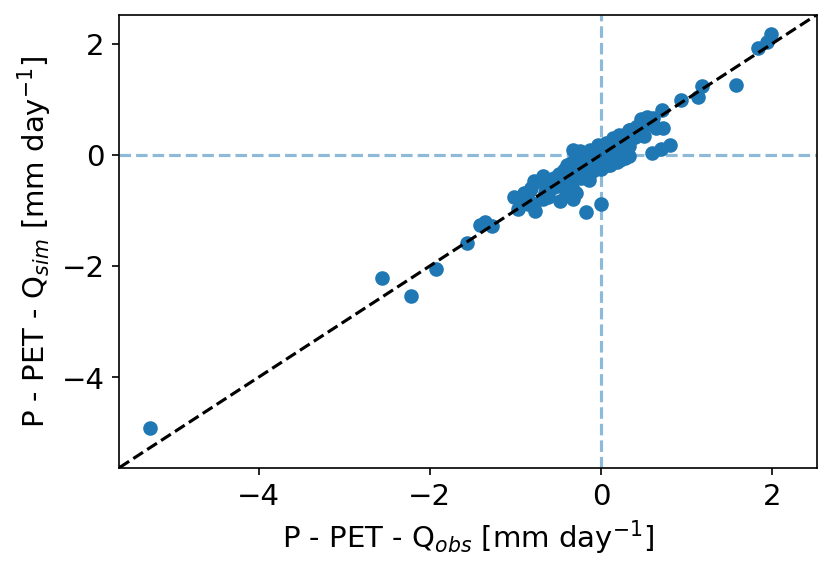

In [206]:
comparison_df = d.rename({"water_balance": "wb_obs"}, axis=1).join(d_sim.rename({"water_balance": "wb_sim"}, axis=1))
f, ax = plt.subplots()
ax.scatter(comparison_df["wb_obs"], comparison_df["wb_sim"])
xlim, ylim = ax.get_xlim(), ax.get_ylim()
axis_min = min(xlim[0], ylim[0])
axis_max = max(xlim[-1], ylim[-1])
ax.set_xlim(axis_min, axis_max)
ax.set_ylim(axis_min, axis_max)
ax.plot(np.linspace(axis_min, axis_max, 100), np.linspace(axis_min, axis_max, 100), color="k", ls="--", label="1:1 Line")

if mm_per_year:
    ax.set_xlabel("P - PET - Q$_{obs}$ [mm yr$^{-1}$]")
    ax.set_ylabel("P - PET - Q$_{sim}$ [mm yr$^{-1}$]")
else:
    ax.set_xlabel("P - PET - Q$_{obs}$ [mm day$^{-1}$]")
    ax.set_ylabel("P - PET - Q$_{sim}$ [mm day$^{-1}$]")

ax.axvline(0, ls="--", alpha=0.5)
ax.axhline(0, ls="--", alpha=0.5)

In [181]:
wb_calculation_sim
wb_calculation_obs

<xarray.DataArray (station_id: 671)>
array([ 1.16754859,  0.94177579,  0.95426996,  1.20165327,  0.26148553,
        1.2540886 ,  1.434501  ,  1.34624375,  0.93202692,  0.97758627,
        1.16039972,  0.52967647,  0.83503241,  1.32984228,  1.05473841,
        1.36978198,  0.7445308 ,  1.79419851,  1.22531335,  0.93397428,
        0.90683111,  0.91137444,  1.04508994,  1.16004125,  1.15984725,
        0.82117259,  0.95566199,  0.95802226,  1.0535721 ,  1.02419564,
        1.08763835,  0.728668  ,  0.86813891,  0.7405338 ,  0.58147389,
        0.21194303,  1.0769171 ,  0.98056223,  1.03252078,  0.88340342,
        1.14787775,  0.93887218,  0.98607546,  1.20344014,  1.24079135,
        1.2985466 ,  0.79894018,  1.07337341,  1.09027604,  3.01362352,
        0.50503171,  1.52098363,  0.79284341, -0.46136988,  1.17506967,
        1.22818654,  1.64562167,  0.82962302,  1.1198788 ,  0.19296555,
        1.01939346,  1.23606584,  0.9326447 ,  2.08269607,  1.30440797,
        1.43879343,  0.98015255,  1.08159901,  1.51569249,  1.18219436,
        1.58934315,  1.43197397,  0.54078633,  1.36912602,  1.64331178,
        1.20613583,         nan,         nan,  1.21372662,  1.17414767,
        0.70641938,  1.29764253,  0.96675736,  1.29456741,  1.31311743,
        1.21757974,  1.25018419,  1.31746988,  1.1123262 ,  1.19826848,
        1.6258238 ,  0.98875697,  1.05987147,  1.1807554 ,  1.27588007,
        0.65071926,  1.25468403,  1.23630396,  1.1176276 ,  1.08358446,
        0.31180345,  1.19636432,  1.22559982,  1.36287339,  1.27491754,
        1.20566569,  1.17334099,  1.16425246,  0.93670413,  1.63147013,
        1.29552749,  0.90168851,  1.43874512,  1.21016552,  1.60453711,
        1.16951014,  1.45855532,  1.2284879 ,  0.90876839,  0.80891948,
        0.8138935 ,  1.41625945,  1.48586386,  1.34051909,  0.95630118,
        2.10684438, -4.85743812,  1.46061377,  1.05497982,  1.36901682,
        1.26731537,  1.09190614,  1.71650822,  1.05795388,  1.23385967,
        1.15077443,  1.22312674,  1.21112086,  1.2982515 ,  1.43437083,
        1.08201687,  3.50971291,  0.9995755 ,  1.10852963, -4.54008905,
        1.3183205 ,  1.11758221,  1.23948668,  0.95649818,  1.13424014,
        1.25302014,  1.1495569 ,  1.2337661 ,  1.65705108,  1.03330889,
       -1.15414879,  1.84258022,  1.00017812,  0.89290793,  1.12254897,
        1.4165377 ,  1.40678435,  1.09289538,  2.45182982,  1.13164536,
        1.24167365,  1.22136179,  1.25766934,  1.54332741,  1.33337359,
        1.22496029,  1.40124706,  1.20903543,  1.210268  ,  0.97356352,
        0.41296797,  1.48477485,  1.58327452,  1.62142455,  1.16890651,
        1.0716205 ,  1.36687995,  1.14973009,  1.45443146,  1.3927039 ,
        1.33356288,  1.76408832,  1.46754606,  1.42652778,  1.45749633,
        1.10702626,  0.54843282,  1.0987366 ,  1.25125125,  1.46195897,
        1.22653505,  1.10055794,  0.12333245,  1.49933083,  1.47289566,
        1.33823732,  1.31924968,  1.08994633,  1.36966847,  1.15570488,
        1.27902131,  1.26824989,  1.61379252,  1.41160295,  1.12449254,
        1.31721221,  1.54105248,  1.53280282,  1.23370077,  1.34994584,
        1.46865274,  1.31600417,  1.24952733,  1.25124689,  1.29344313,
        1.3024466 ,  1.30584712,  1.36316528,  1.35530997,  1.38507007,
        1.38707396,  1.23996962,  1.30694344,  1.25918842,  1.35166369,
        1.27287926,  1.62354851,  1.39957863,  1.34333885,  1.04424199,
        1.43834862,  1.35858754,  1.64562003,  1.25242436,  1.34466436,
        1.38057847,  1.24683002,  1.52737309,  0.95202507,  1.12515751,
        1.41275405,  1.39028846,  1.396036  ,  1.62624537,  1.33739103,
        1.27435226,  1.21873709,  1.33513035,  1.59376719,  1.64374998,
        1.26010686,  1.23391919,  1.33419817,  1.27482347,  1.31001592,
        1.30298883,  1.11852457,  0.98512999,  1.23428702,  1.26462366,
        1.30008966,  1.23652297,  1.09739715,  1.21656062,  1.32322465,
        1.08798553,  1.13845538,  1.27105189,  1.20481124,  1.1548922 ,
   

In [182]:
pminus_sim = wb_calculation_sim.to_dataframe("pminusq_sim")
pminus_obs = wb_calculation_obs.to_dataframe("pminusq_obs")

# Geospatial Plots

In [200]:
assert False, "Do you want to run the geospatial plots?"

AssertionError: Do you want to run the geospatial plots?

In [163]:
import geopandas as gpd

shp_path = data_dir / "CAMELS_GB_DATASET/Catchment_Boundaries/CAMELS_GB_catchment_boundaries.shp"
assert shp_path.exists()

# load in the shapefile
geo_df = gpd.read_file(shp_path)
geo_df['ID_STRING'] = geo_df['ID_STRING'].astype('int')
geo_df.crs = {'init' :'epsg:27700'}  # 4277  27700

assert (data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp").exists(), "Download the natural earth hires from https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_0_countries.zip"
world = gpd.read_file(data_dir / "RUNOFF/natural_earth_hires/ne_10m_admin_0_countries.shp")
uk = world.query("ADM0_A3 == 'GBR'")

In [164]:
def create_spatial_dataframe(data_df: pd.DataFrame, geo_df: gpd.GeoDataFrame, polygon: bool = False) -> gpd.GeoDataFrame:
    assert data_df.index.dtype == geo_df['ID_STRING'].dtype, "Need to be the same type (integer)"
    data_gdf = gpd.GeoDataFrame(
        geo_df.set_index('ID_STRING').join(data_df)
    )
    if not polygon:
        static_df = static.to_dataframe()
        d = static_df[["gauge_lat", "gauge_lon"]]

        points = gpd.GeoSeries(gpd.points_from_xy(d["gauge_lon"], d["gauge_lat"]), index=d.index)
        points.name = "geometry"
        data_gdf = data_gdf.drop("geometry", axis=1).join(points)
        data_gdf.crs = {'init' :'epsg:4326'}
    else:
        data_gdf.crs = {'init' :'epsg:27700'}
        
    return data_gdf

In [258]:
# balance_df.loc[balance_df["balance"]]

,ID,SOURCE,VERSION,EXPORTED,balance,geometry
ID_STRING,,,,,,
10003,10003.0,National River Flow Archive,1.3,2018-02-12,True,POINT (-2.09000 57.36000)
101002,101002.0,National River Flow Archive,1.3,2018-02-12,True,POINT (-1.29000 50.69000)
11001,11001.0,National River Flow Archive,1.3,2018-02-12,True,POINT (-2.19000 57.22000)
11003,11003.0,National River Flow Archive,1.3,2018-02-12,True,POINT (-2.72000 57.24000)
12001,12001.0,National River Flow Archive,1.3,2018-02-12,True,POINT (-2.60000 57.05000)
...,...,...,...,...,...,...
9005,9005.0,National River Flow Archive,1.3,2018-02-12,True,POINT (-3.03000 57.35000)
94001,94001.0,National River Flow Archive,1.3,2018-02-12,True,POINT (-5.60000 57.76000)
96001,96001.0,National River Flow Archive,1.3,2018-02-12,True,POINT (-3.90000 58.48000)


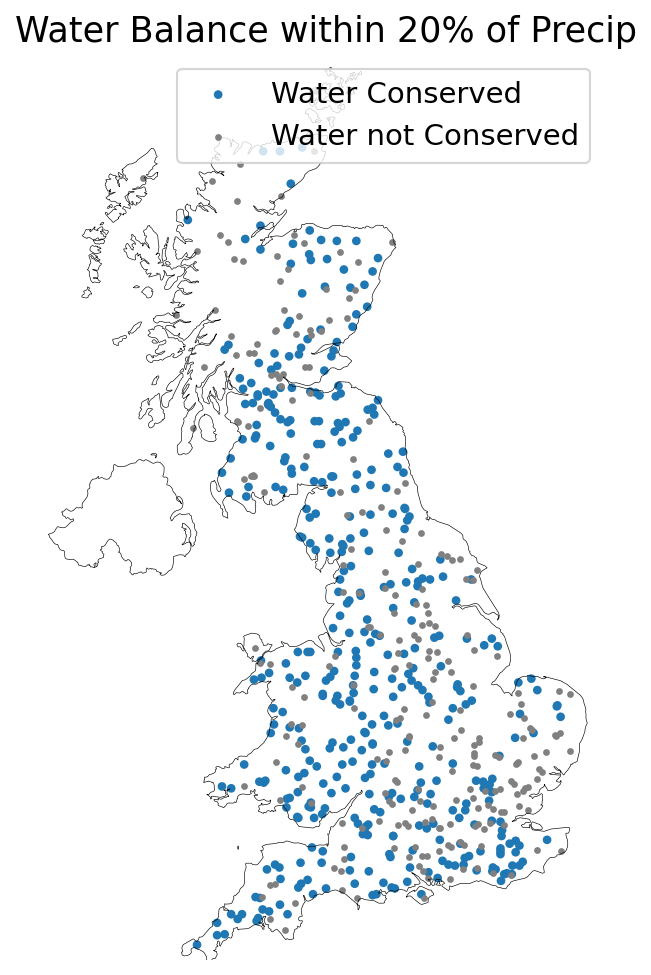

In [265]:
balance_df = create_spatial_dataframe(bool_wb.to_dataframe("balance"), geo_df)

f, ax = plt.subplots(figsize=(12, 8))
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
# plot the chloropleth
# balance_df.to_crs(epsg=4326).plot("balance", ax=ax, legend=True, cax=cax, **opts);
balance_df.loc[balance_df["balance"]].plot("VERSION", legend=False, ax=ax, markersize=10, label="Water Conserved")
balance_df.loc[~balance_df["balance"]].plot("VERSION", legend=False, ax=ax, markersize=5, color="grey", label="Water not Conserved")

# plot the surrounding lines
uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)

ax.set_xlim([-8.2, 2.1])
ax.set_ylim([50, 59.5])
ax.set_title("Water Balance within 20% of Precip")
ax.legend()
ax.axis('off');

In [183]:
sim_wb_gdf = create_spatial_dataframe(d_sim.rename({"water_balance": "wb_sim"}, axis=1), geo_df)
# obs_wb_gdf = create_spatial_dataframe(d.rename({"water_balance": "wb_obs"}, axis=1), geo_df)
wb_gdf = sim_wb_gdf.join(d.rename({"water_balance": "wb_obs"}, axis=1))
wb_gdf = wb_gdf.join(pminus_sim)
wb_gdf = wb_gdf.join(pminus_obs)

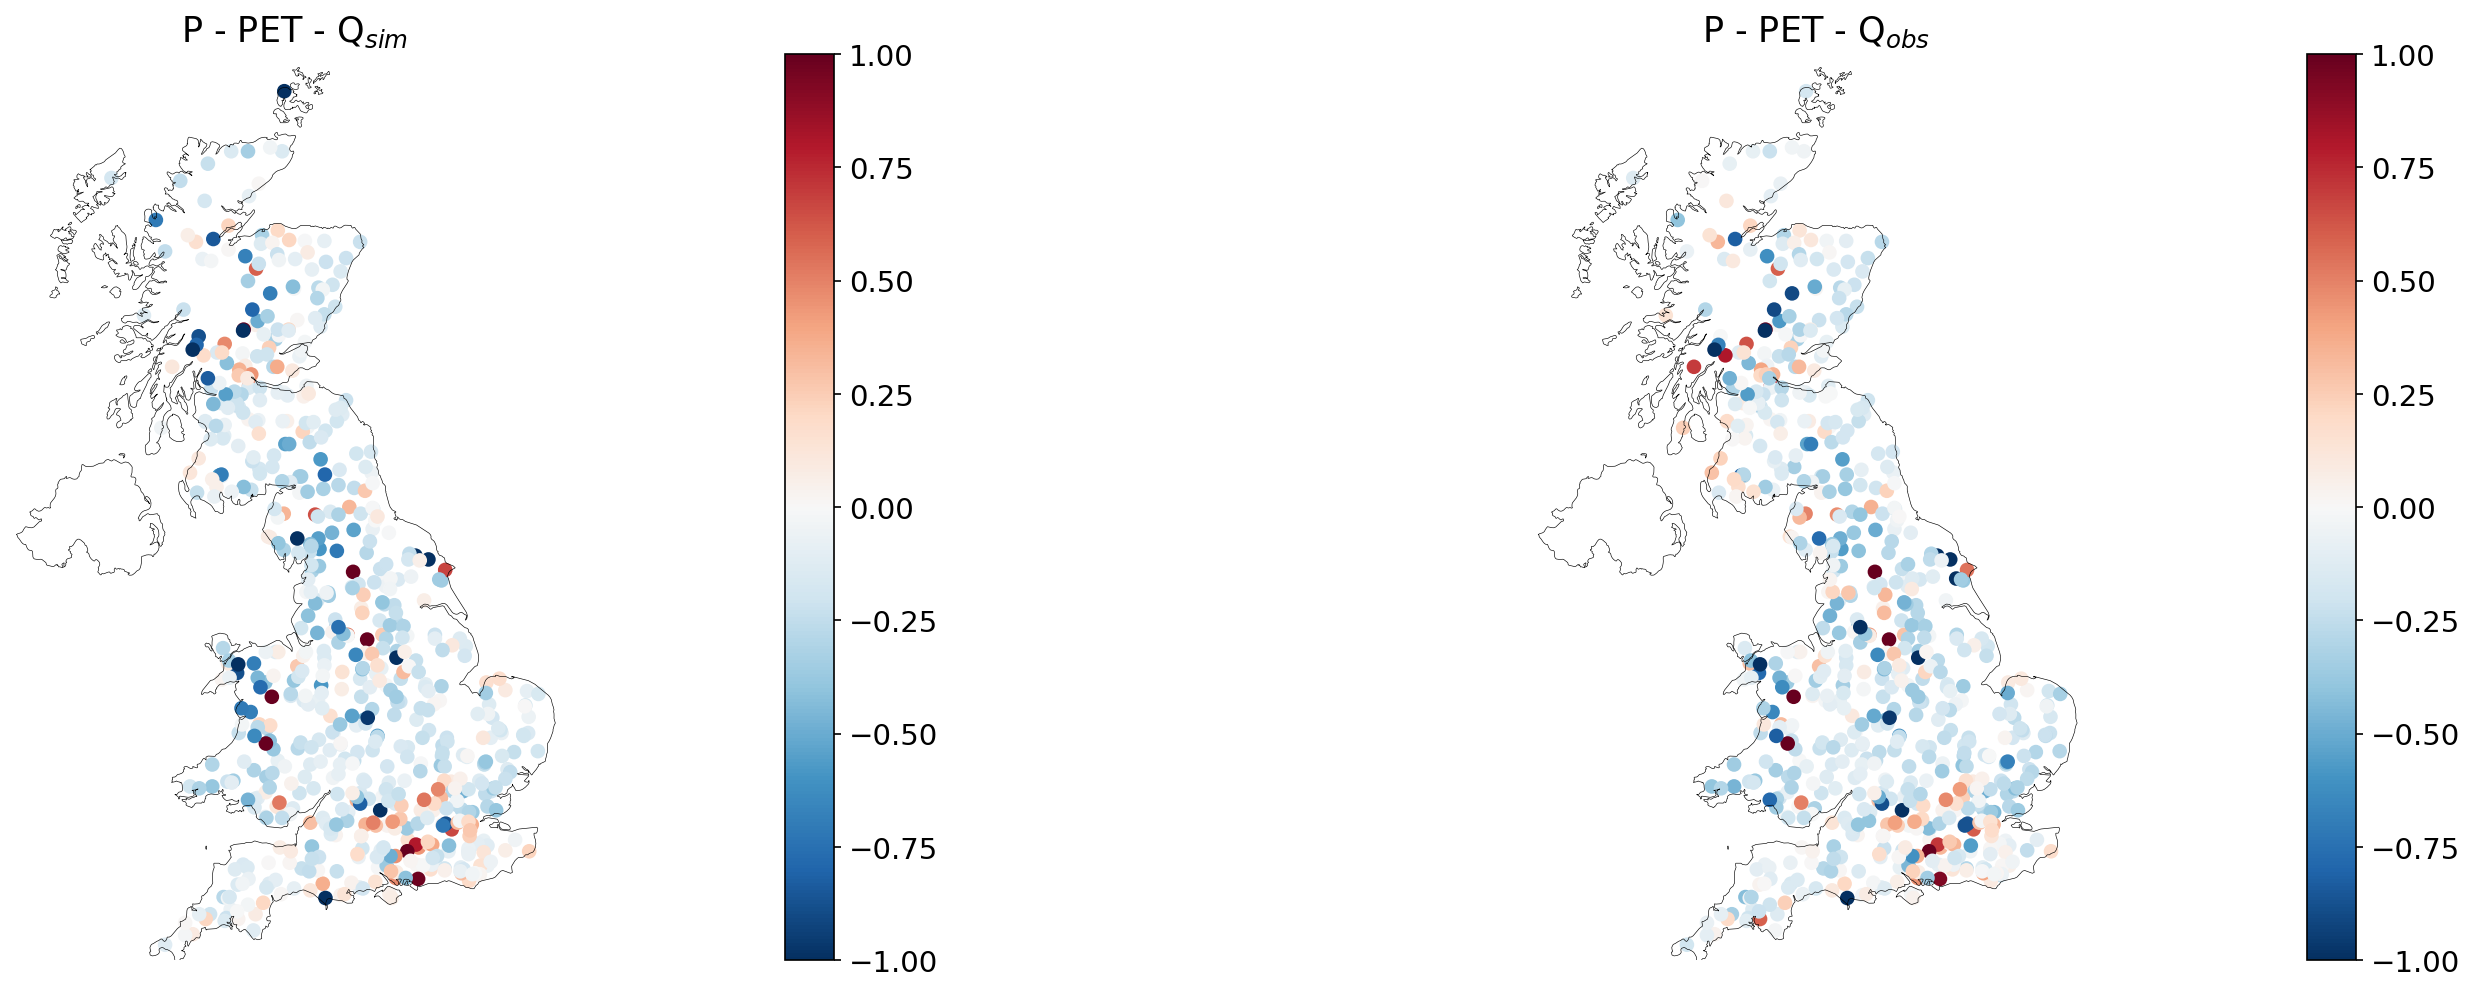

In [187]:
scale = 2
f, axs = plt.subplots(1, 2, figsize=(6*scale*2, 4*scale))
opts = {"vmin": -1, "vmax": 1, "cmap": "RdBu_r"}

for ix, metric in enumerate(["wb_sim", "wb_obs"]):
    ax = axs[ix]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
    # plot the chloropleth
    wb_gdf.to_crs(epsg=4326).plot(metric, ax=ax, legend=True, cax=cax, **opts);

    # plot the surrounding lines
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)

    ax.set_xlim([-8.2, 2.1])
    ax.set_ylim([50, 59.5])
    ax.set_title("P - PET - Q$_{sim}$" if metric == "wb_sim" else "P - PET - Q$_{obs}$")
    ax.axis('off');

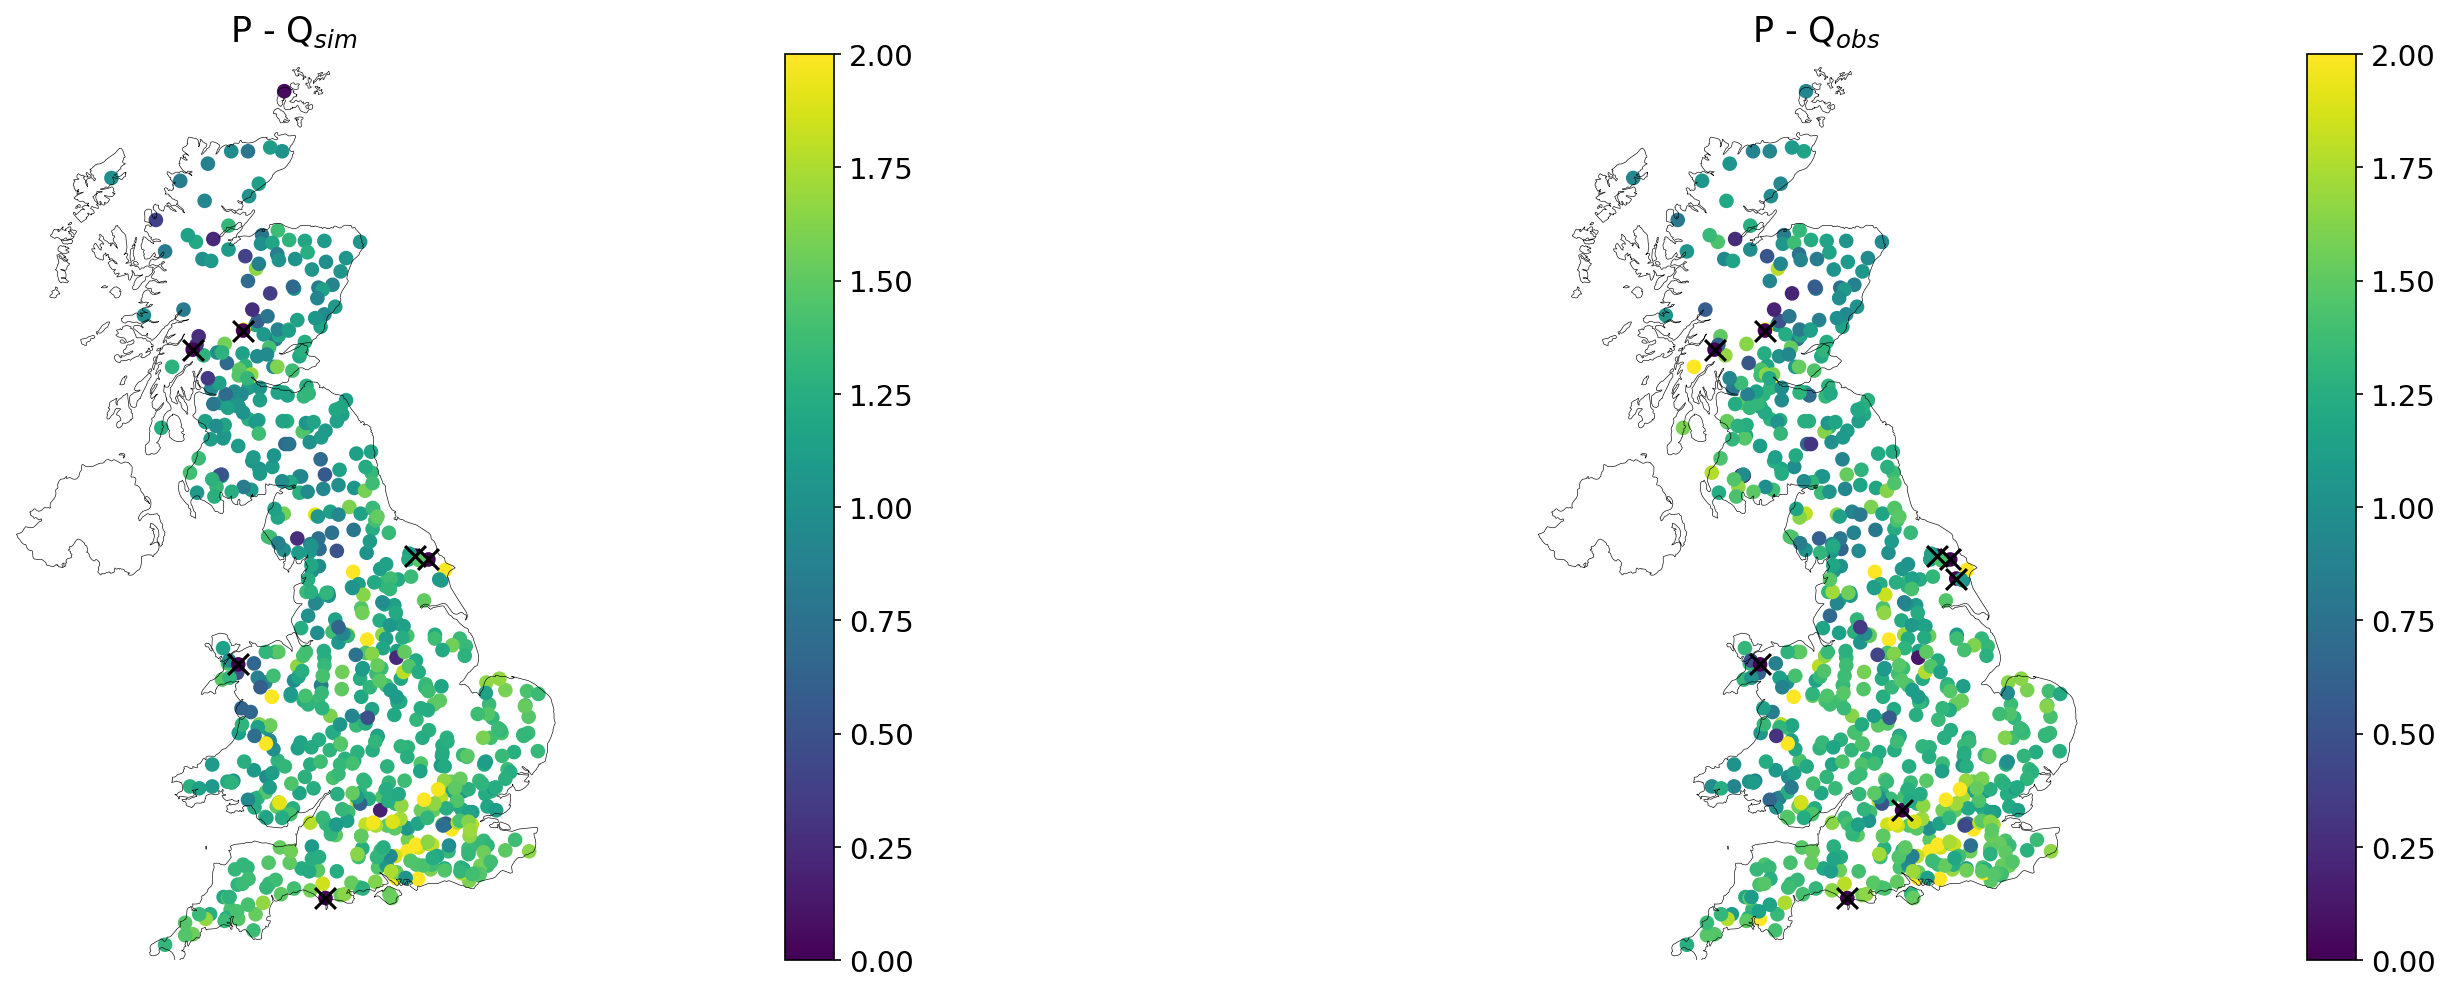

In [199]:
f, axs = plt.subplots(1, 2, figsize=(6*scale*2, 4*scale))
opts = {"vmin": 0, "vmax": 2, "cmap": "viridis"}
for ix, metric in enumerate(["pminusq_sim", "pminusq_obs"]):
    ax = axs[ix]
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
    # plot the chloropleth
    wb_gdf.to_crs(epsg=4326).plot(metric, ax=ax, legend=True, cax=cax, **opts);
    wb_gdf.loc[wb_gdf[metric] < 0].to_crs(epsg=4326).plot(metric, color="k", markersize=100, marker="x", ax=ax)

    # plot the surrounding lines
    uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)

    ax.set_xlim([-8.2, 2.1])
    ax.set_ylim([50, 59.5])
    ax.set_title("P - Q$_{sim}$" if metric == "pminusq_sim" else "P - Q$_{obs}$")
    ax.axis('off');
    
    

In [152]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
markersize = 10
# "scheme": "quantiles" if quantiles else None
opts = {
    "rmse": {"vmin": 0, "vmax": 1, 'cmap': 'viridis', "markersize": markersize},   # rmse   
    "rmse_norm": {"vmin": 0, "vmax": 0.5, 'cmap': 'viridis', "markersize": markersize},   # rmse   
    "nse": {"vmin": 0.7, "vmax": 1, 'cmap': 'viridis_r', "markersize": markersize},    # nse  8
    "kge": {"vmin": 0.7, "vmax": 1, 'cmap': 'plasma_r', "markersize": markersize},    # kge   
    "bias": {"vmin": -20, "vmax": 20, 'cmap': 'RdBu', "markersize": markersize}    # bias  
}

from typing import List 

def plot_geospatial_data(model_data, model: str, metrics: List[str] = ["nse", "bias", "kge"]):
    
    fig, axs = plt.subplots(1, 3, figsize=(5*3, 8))
    
    for ix, metric in enumerate(metrics):
        ax = axs[ix]
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.001) # depends on the user needs
        # plot the chloropleth
        model_data.to_crs(epsg=4326).plot(metric, ax=ax, legend=True, cax=cax, **opts[metric]);
        
        # plot the surrounding lines
        uk.plot(facecolor='none', edgecolor='k', ax=ax, linewidth=0.3)
        
        ax.set_xlim([-8.2, 2.1])
        ax.set_ylim([50, 59.5])
        ax.axis('off');

        ax.set_title(metric.upper())

#     fig.tight_layout(rect=[0, 0.03, 1, 0.965]);
#     fig.suptitle(f"{model} Model Error", size=14);